In [1]:
import csv, cv2, os, random, sklearn
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def collect_DATA(dataPath, correction):
    """
    Finds all the images needed for training on the path `dataPath`.
    Combine the Centre, Left and Right images and steering angles and returns (all_Images, all_Angles)
    """
    directories = [x[0] for x in os.walk(dataPath)]
    dataDirectories = list(filter(lambda directory: os.path.isfile(directory + '/driving_log.csv'), directories))
    centerTotal = []
    leftTotal = []
    rightTotal = []
    measurementTotal = []
    for directory in dataDirectories:
        #lines = getLinesFromDrivingLogs(directory)
        lines = []
        with open(dataPath + '/driving_log.csv') as csvFile:
            reader = csv.reader(csvFile)
            for line in reader:
                lines.append(line)

        center = []
        left = []
        right = []
        measurements = []
        for line in lines:
            measurements.append(float(line[3]))
            center.append(directory + '/' + line[0].strip())
            left.append(directory + '/' + line[1].strip())
            right.append(directory + '/' + line[2].strip())
        images = []
        angles = []
        images.extend(center)
        images.extend(left)
        images.extend(right)
        angles.extend(measurements)
        angles.extend([x + correction for x in measurements])
        angles.extend([x - correction for x in measurements])
    return (images, angles)

In [3]:
def display(images,measurements):
    #Sample pics with their respective steering angles..
    f, ax = plt.subplots(4,2,figsize=(15,15))
    for i in range(4):
        for j in range(1):
            index=random.randint(0,len(images))
            image = cv2.imread(images[index])
            ax[i,0].imshow(image)#images[index,:,:,:])
            ax[i,0].set_title('Steering Angle: {}'.format(measurements[index]))
            index=random.randint(0,len(images))
            image = cv2.imread(images[index])
            ax[i,1].imshow(image)#images[index,:,:,:])
            ax[i,1].set_title('Steering Angle: {}'.format(measurements[index]))

Total #Images: 11277
SAMPLES:


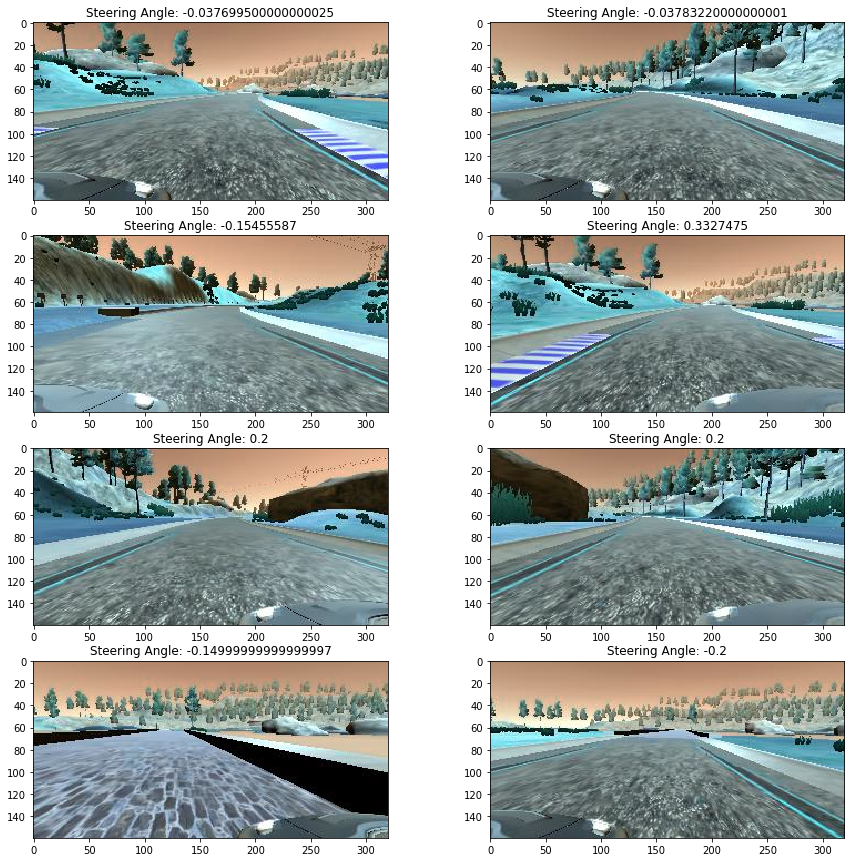

In [4]:
images, measurements = collect_DATA('/Users/rickerish_nah/Documents/Udacity_aws/data', 0.2)
print("Total #Images:",len(images))
#Display sample pictures
print("SAMPLES:")
display(images,measurements)


(array([  16.,   44.,  156.,  646., 3369., 5863.,  906.,  233.,   34.,
          10.]),
 array([-1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,  0.48,  0.72,
         0.96,  1.2 ]),
 <a list of 10 Patch objects>)

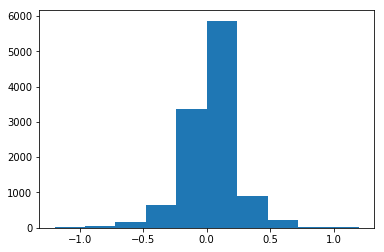

In [5]:
plt.hist(measurements)

In [6]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Dropout, Cropping2D

Using TensorFlow backend.


In [8]:
def generator(samples, batch_size=32):
    """
    Generate the required images and measurments for training/
    `samples` is a list of pairs (`imagePath`, `measurement`).
    """
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                #print(imagePath)
                image = cv2.imread(imagePath)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                image = cv2.resize(image, (0,0), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
                #image = image[50:image.shape[0]-20,:,:]
          
                images.append(image)
                angles.append(measurement)
                # Flipping
                images.append(cv2.flip(image,1))
                angles.append(measurement*-1.0)
            
            inputs = np.array(images)
            #norm = lambda x: ((x/255.0)-0.5)
            #inputs = norm(inputs)
            outputs = np.array(angles)
            yield sklearn.utils.shuffle(inputs, outputs)

In [12]:
def nVidiaModel():
    """
    nVidea Autonomous Car Group model
    """
    model = Sequential()
    #model.add(Cropping2D(cropping=((50,20), (0,0))))
    model.add(Conv2D(24,(5,5),padding='valid', activation='relu', input_shape=(80,160,3), subsample=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(36,(5,5),padding='valid', activation='relu',subsample=(2,2)))
    model.add(Conv2D(48,(5,5),padding='valid', activation='relu',subsample=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64,(3,3),padding='valid', activation='relu'))
    model.add(Conv2D(64,(3,3),padding='valid', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1164,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dropout(0.25))
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [13]:
samples = list(zip(images, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
# Model creation
model = nVidiaModel()
# Compiling and training the model  ::   ::  
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

Train samples: 9021
Validation samples: 2256


/Users/rickerish_nah/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), padding="valid", activation="relu", input_shape=(80, 160, ..., strides=(2, 2))`
/Users/rickerish_nah/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), padding="valid", activation="relu", strides=(2, 2))`
/Users/rickerish_nah/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), padding="valid", activation="relu", strides=(2, 2))`


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 38, 78, 24)        1824      
_________________________________________________________________
dropout_2 (Dropout)          (None, 38, 78, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 37, 36)        21636     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 17, 48)         43248     
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 17, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 15, 64)         27712     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 13, 64)         36928     
__________